### Notebook to explore supervised prediction of magnetic flux data

In [1]:
import numpy as np
import os, sys, shutil
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import json, pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
sys.path.insert(0, '../utils')
import data_utils, run_utils, eval_utils
import importlib

#### UNet for Magentic Flux Prediction

In [2]:
'''
Quickly summarize trained models
'''

importlib.reload(run_utils)
mods = run_utils.get_unetDF(modeldir='../../model_runs_seg/UNet_runs')
mods

AttributeError: module 'run_utils' has no attribute 'get_unetDF'

80


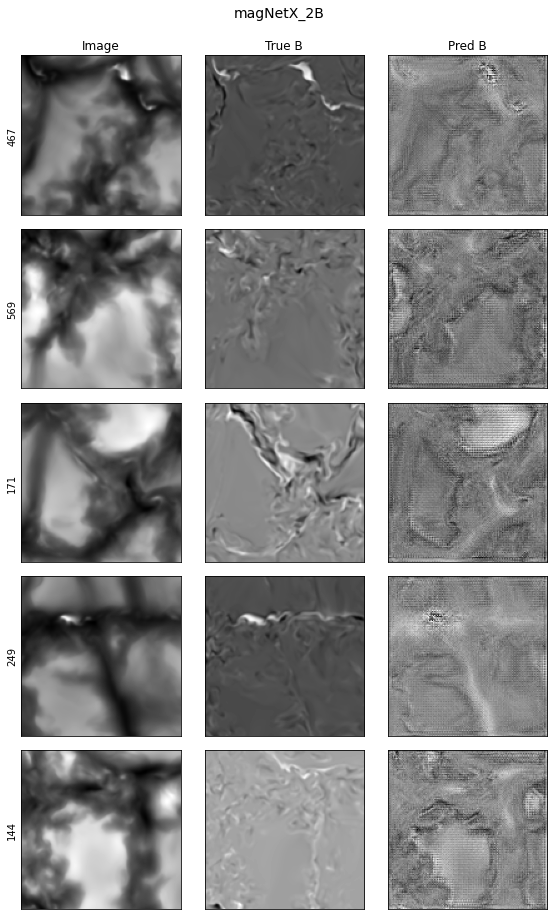

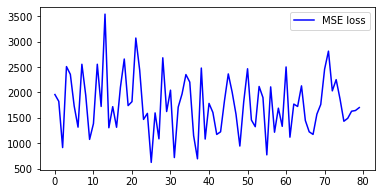

In [4]:
'''
Display a random sample of images for one model
'''

magNet_name = 'magNetX_2B' 
output_dir = f'../../model_runs_seg/UNet_runs/{magNet_name}/test_preds_MURaM'
fig, axs = plt.subplots(5, 3, figsize=(8, 13))
axs[0,0].set_title('Image')
axs[0,1].set_title('True B')
axs[0,2].set_title('Pred B')
target_pos = 2 if 'timeseries' in mods[mods['UNet_name']==f"{magNet_name}"] else 0
for i in range(5): 
    idx = np.random.randint(0, len([file for file in os.listdir(output_dir) if file.startswith('x')]))
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos]
    true = np.load(f'{output_dir}/true_{idx}.npy')[0]
    preds = np.load(f'{output_dir}/pred_{idx}.npy')[0]
    axs[i,0].imshow(im, cmap='gist_gray'); axs[i,0].set_ylabel(idx)
    axs[i,1].imshow(true, cmap='gist_gray')
    axs[i,2].imshow(preds, cmap='gist_gray')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.suptitle(f'{magNet_name}\n', fontsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/{magNet_name}_val_examples')

'''
Check losses
'''
losses = np.load(f'../../model_runs_mag/UNet_runs/{magNet_name}/losses.npy')
print(len(losses))
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(losses, color='b', label='MSE loss')
ax.legend()

In [2]:
'''
Run magNet in notebook for debugging
 - sbatch Solar_Segmentation/run_UNet.sh -f unet_exp_file.json
 - sbatch Solar_Segmentation/run_model.sh -f net0_exp_file.json
 - sbatch Solar_Segmentation/run_model.sh -f ../model_runs_mag/Net0_runs/Net0X_1A/exp_file.json
'''
import sys, json, importlib 
sys.path.insert(0, '../utils')
import data_utils, run_utils, models
sys.path.insert(0, '../')
import run_UNet
importlib.reload(data_utils)
importlib.reload(run_UNet)


exp_dicts = json.load(open('../../Solar_Segmentation/unet_exp_file.json'))
if isinstance(exp_dicts, dict): # If experiment file is a single dict, not a list of dicts
    exp_dicts = [exp_dicts]
for d in exp_dicts:
    print(f'RUNNING EXPERIMENT {d["UNet_name"]} \nexp dict: {d}')
    run_UNet.run_unet_model(d, gpu='False')
    print(f'DONE')
print('FINISHED ALL EXPERIMENTS')

RUNNING EXPERIMENT magUNetX_2B 
exp dict: {'UNet_name': 'magUNetX_2B', 'sub_dir': 'UNet_runs', 'n_classes': 3, 'channels': ['X', 'X**2', 'gradx', 'grady'], 'weights': [1, 2, 1, 1], 'img_dir': 'UNetData_MURaM/norm_images/', 'true_dir': 'UNetData_MURaM/mag_images/', 'img_size': 128, 'randomSharp': 'False', 'loss_func': 'MSE', 'bp_wght': 'None', 'num_epochs': 80, 'batch_size': 16, 'learning_rate': 0.1}
Experiment output dir /projects/lezu7058/SolarML_2023/Solar_Segmentation/exploration/../../model_runs_mag/UNet_runs/magUNetX_2B/ already exists - contents will be overwritten
Copying exp dict into /projects/lezu7058/SolarML_2023/Solar_Segmentation/exploration/../../model_runs_mag/UNet_runs/magUNetX_2B//exp_file.json
Loading data from UNetData_MURaM/norm_images/ and UNetData_MURaM/mag_images/
Train data:
     1890 obs, broken into 119 batches
     Each batch has data of shape torch.Size([16, 4, 128, 128]), e.g. 16 images, [128, 128] pixels each, 4 layers (features)
     Each batch has labels

AttributeError: module 'utils.models' has no attribute 'magNet'

#### DeepVel CNN for Magnetic Flux Prediction

In [4]:
'''
Quickly summarize trained models
'''
importlib.reload(eval_utils)
mods = eval_utils.get_netDF(modeldir='../../model_runs_mag/deepVel_runs')
mods

Skipping .ipynb_checkpoints; not finished training


,net_name,model,channels,weights,loss_func,ne,batch_size,lr,RMSE,norm
2,deepVel_1A,DeepVel,"[X, median_residual]","[1, 1]",multichannel_MSE_loss,10,16,0.01,40.761516,image
0,deepVel_1B,DeepVel,"[X, median_residual]","[1, 2]",multichannel_MSE_loss,15,16,0.03,40.762782,image
1,deepVel_2A,DeepVel,"[X, median_residual]","[1, 1]",multichannel_MSE_loss,10,16,0.01,0.915024,full


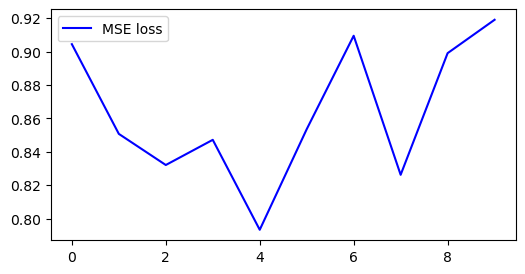

In [6]:
'''
Check losses look ok 
'''
net_dir = "deepVel_runs"#"Net0_runs"
net_name = "deepVel_2A"#"Net0X_2A"
losses = np.load(f'../../model_runs_mag/{net_dir}/{net_name}/losses.npy')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(losses, color='b', label='MSE loss')
ax.legend()

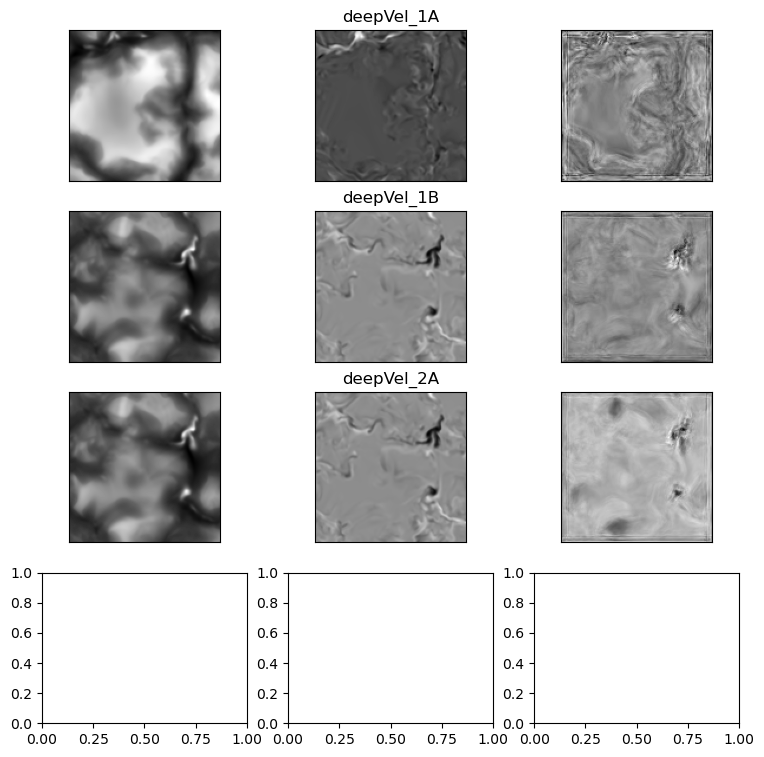

In [7]:
'''
Compare models 
'''
ts40idx = 108 # 58
ts80idx = 20 # FIND A GOOD ONE
nontsidx = 692 # 51, 131 # 161  # 131 # dont want to go through timeseries test sets to actually find the imageset that whose target image is idx 131 in the non-TS test set
ms = [m for m in mods['net_name']]# if m not in ignore] # [n.replace('WNet','') for n in mods['WNet_name']] # ['29nm','29nm_a','32nm','32nm_a','33nm','34nm','34nm_a'] # models on properly normalized data!
fig, axs = plt.subplots(len(ms)+1, 3, figsize=(9, 3*len(ms)))
for i in range(len(ms)):
    output_dir = f'../../model_runs_mag/{net_dir}/{ms[i]}/test_preds_MURaM'
    idx = ts40idx if 'T_1' in ms[i] else ts80idx if 'T_2' in ms[i] else nontsidx 
    im = np.load(f'{output_dir}/x_{idx}.npy')[0]
    true = np.load(f'{output_dir}/true_{idx}.npy')[0]
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,1].set_title(f'{ms[i]}')
    axs[i,0].imshow(im, cmap='gist_gray')
    axs[i,1].imshow(true, cmap='gist_gray')
    axs[i,2].imshow(preds, cmap='gist_gray')#cmap='tab10')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])

In [ ]:
'''
Run magnetic flux models in notebook for debugging
 - sbatch Solar_Segmentation/run_UNet.sh -f unet_exp_file.json
 - sbatch Solar_Segmentation/run_model.sh -f net0_exp_file.json
 - sbatch Solar_Segmentation/run_model.sh -f ../model_runs_mag/Net0_runs/Net0X_1A/exp_file.json
'''
import sys, json, importlib 
sys.path.insert(0, '../utils')
import data_utils, run_utils, models
sys.path.insert(0, '../')
import run_model
importlib.reload(data_utils)
importlib.reload(run_model)
importlib.reload(models)


exp_dicts = json.load(open('../../Solar_Segmentation/deepvel_exp_file.json'))
if isinstance(exp_dicts, dict): # If experiment file is a single dict, not a list of dicts
    exp_dicts = [exp_dicts]
for d in exp_dicts:
    print(f'RUNNING EXPERIMENT {d["net_name"]} \nexp dict: {d}')
    run_model.run_model(d, gpu='False')
    print(f'DONE')
print('FINISHED ALL EXPERIMENTS')

RUNNING EXPERIMENT deepVel_1A 
exp dict: {'net_name': 'deepVel_1A', 'sub_dir': 'deepVel_runs', 'model': 'DeepVel', 'channels': ['X', 'median_residual'], 'weights': [1, 1], 'img_dir': 'UNetData_MURaM/norm_images/', 'true_dir': 'UNetData_MURaM/mag_images/', 'img_size': 128, 'randomSharp': 'False', 'loss_func': 'multichannel_MSE_loss', 'num_epochs': 10, 'batch_size': 16, 'learning_rate': 0.01}
Experiment output dir /projects/lezu7058/SolarML_2023/Solar_Segmentation/exploration/../../model_runs_mag/deepVel_runs/deepVel_1A/ already exists - contents will be overwritten
Copying exp dict into /projects/lezu7058/SolarML_2023/Solar_Segmentation/exploration/../../model_runs_mag/deepVel_runs/deepVel_1A//exp_file.json
Loading data from UNetData_MURaM/norm_images/ and UNetData_MURaM/mag_images/
Train data:
     1890 obs, broken into 119 batches
     Each batch has data of shape torch.Size([16, 2, 128, 128]), e.g. 16 images, [128, 128] pixels each, 2 layers (features)
     Each batch has labels of s

#### Traditional ML for Magnetic Flux Prediction

OLS test RMSE: 44.10549
SGD test RMSE: 44.10574304475746


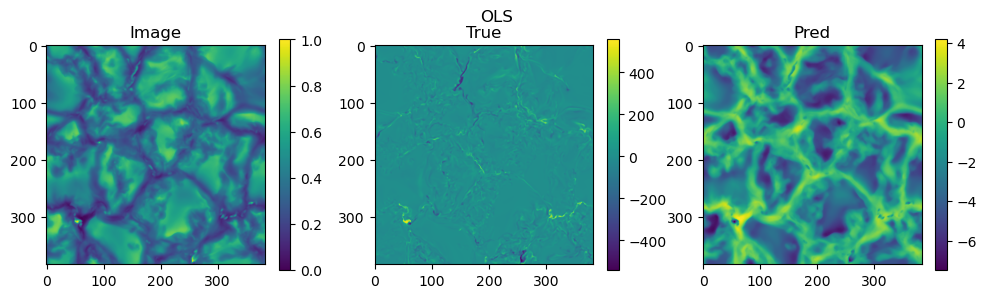

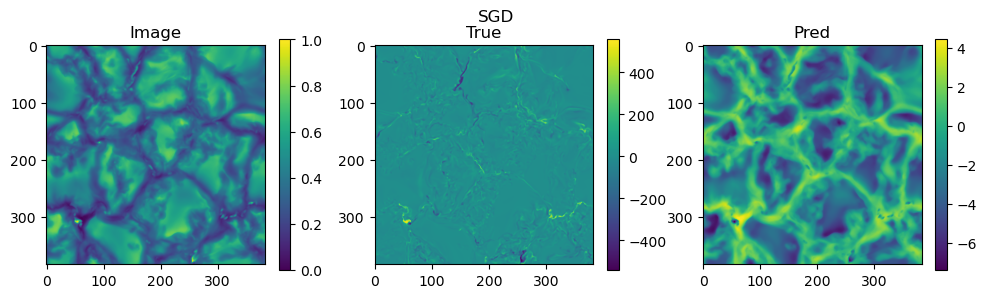

In [3]:
'''
Linear models
'''
from sklearn import linear_model as lm

#X_train, X_test, Y_train, Y_test = pickle.load(open('../../Data/tradData_MURaM_mag_subset.pkl','rb'))#.newbyteorder().byteswap()
X_train, Y_train = pickle.load(open('../../Data/tradData_MURaM_mag_train_subset.pkl','rb')) #    #.newbyteorder().byteswap()
X_test, Y_test = pickle.load(open('../../Data/tradData_MURaM_mag_test_subset.pkl','rb'))#.newbyteorder().byteswap()
X_train = X_train[["value", "med8res"]]
N = int(np.sqrt(len(X_test[0])))

# Simple OLS
model = lm.LinearRegression()
model.fit(X_train, Y_train)
rmses = []
for i in range(len(X_test)): # X_test is *list* of DFs, not single DF
    X = X_test[i][["value", "med8res"]]
    pred = model.predict(X)
    true = Y_test[i]
    rmses.append(np.sqrt(np.mean((true-pred)**2)))
fig, axs = plt.subplots(1, 3, figsize=(12,3)); #plot_idxs = np.random.choice(np.linspace(0, len(X_test)-1, len(X_test)), 3)
im0 = axs[0].imshow(np.reshape(X['value'], (N, N))); plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(np.reshape(true, (N, N))); plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(np.reshape(pred, (N, N))); plt.colorbar(im2, ax=axs[2])
plt.suptitle('OLS')
axs[0].set_title('Image'); axs[1].set_title('True'); axs[2].set_title('Pred')
print('OLS test RMSE:', np.mean(rmses))#metrics.root_mean_sqaured_error(Y_test, pred))

# SGD
model = lm.SGDRegressor()
model.fit(X_train, Y_train)
rmses = []
for i in range(len(X_test)): # X_test is *list* of DFs, not single DF
    X = X_test[i][["value", "med8res"]]
    pred = model.predict(X)
    true = Y_test[i]
    rmses.append(np.sqrt(np.mean((true-pred)**2)))
fig, axs = plt.subplots(1, 3, figsize=(12,3)); #plot_idxs = np.random.choice(np.linspace(0, len(X_test)-1, len(X_test)), 3)
im0 = axs[0].imshow(np.reshape(X['value'], (N, N))); plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(np.reshape(true, (N, N))); plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(np.reshape(pred, (N, N))); plt.colorbar(im2, ax=axs[2])
plt.suptitle('SGD')
axs[0].set_title('Image'); axs[1].set_title('True'); axs[2].set_title('Pred')
print('SGD test RMSE:', np.mean(rmses))#metrics.root_mean_sqaured_error(Y_test, pred))